# Short-Time Energy

In [2]:
#We'll start out code by importing global functionality:

In [3]:
from __future__ import division      # so, 1/2 == 0.5 (forces real-valued division)

In [4]:
#The scipy.io.wavfile code allows for basic manipulation of wave file audio.

In [5]:
from scipy.io import wavfile
 
# pick one file name:
##fName = '003_A_male_167Hz.wav'
fName = 'boy.wav'
fs, signal = wavfile.read(fName)
signal = signal / max(abs(signal))                        # scale signal
assert min(signal) >= -1 and max(signal) <= 1
print ('fs           ==> ', fs, 'Hz')                      # sampling rate
print ('len(signal)  ==> ', len(signal), 'samples')

fs           ==>  16000 Hz
len(signal)  ==>  8000 samples


In [6]:
#Since fs and len(signal) are the same, the duration of the signal is one second.
#Here are some plots of the signal we are dealing with:

TypeError: unsupported operand type(s) for /: 'int' and 'NoneType'

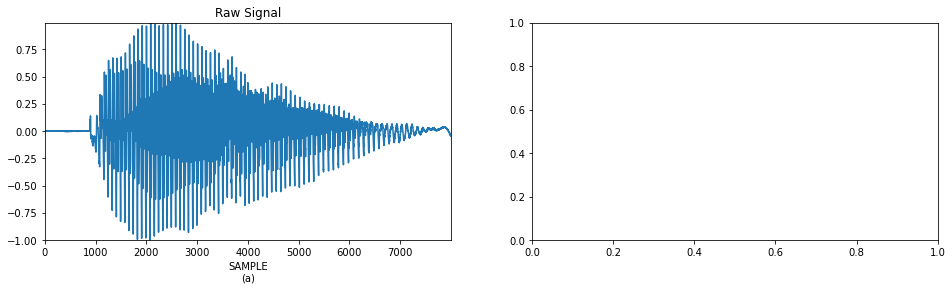

In [14]:
from numpy import linspace
_, (sp1, sp2) = plt.subplots(1, 2, figsize=(16, 4))
# plot raw signal
sp1.plot(signal)
sp1.set_title('Raw Signal')
sp1.set_xlabel('SAMPLE\n(a)')
sp1.autoscale(tight='both')
# plot spectrogram
sp2.specgram(signal)
sp2.set_title('Spectogram')
sp2.set_xlabel('TIME\n(b)')
nSecs = len(signal) / fs
ticksPerSec = 3
nTicks = nSecs * ticksPerSec + 1                # add 1 to include time=0
xTickMax = sp2.get_xticks()[-1]
sp2.set_xticks(linspace(0, xTickMax, nTicks))
sp2.set_xticklabels([round(x, 2) for x in linspace(0, nSecs, nTicks)])
sp2.set_ylabel('FREQ')
maxFreq = fs / 2
nTicks = maxFreq / 1000 + 1                     # add 1 to include freq=0
sp2.set_yticks(linspace(0, 1, nTicks))
sp2.set_yticklabels(linspace(0, maxFreq, nTicks));
sp2.autoscale(tight='both')

In [8]:
#If you want to hear it:

In [31]:
from IPython import display
display.HTML("<audio controls><source src='{}'></audio>".format('boy.wav'))

In [ ]:
#First we'll compute some statistics:

In [33]:
assert fs % 1000 == 0
 
sampsPerMilli = int(fs / 1000)
millisPerFrame = 20
sampsPerFrame = sampsPerMilli * millisPerFrame
nFrames = int(len(signal) / sampsPerFrame)        # number of non-overlapping _full_ frames

print( 'samples/millisecond  ==> ', sampsPerMilli)
print ('samples/[%dms]frame  ==> ' % millisPerFrame, sampsPerFrame)
print ('number of frames     ==> ', nFrames)
 

samples/millisecond  ==>  16
samples/s]frame  ==>  320
number of frames     ==>  25


In [ ]:
#Now we'll process each frame in turm:

In [36]:
import numpy
STEs = []                                      # list of short-time energies
for k in range(nFrames):
    startIdx = k * sampsPerFrame
    stopIdx = startIdx + sampsPerFrame
    window = numpy.zeros(signal.shape)
    window[startIdx:stopIdx] = 1               # rectangular window
    STE = sum((signal ** 2) * (window ** 2))
    STEs.append(STE)

In [ ]:
#Here's a plot of the short-time energies:

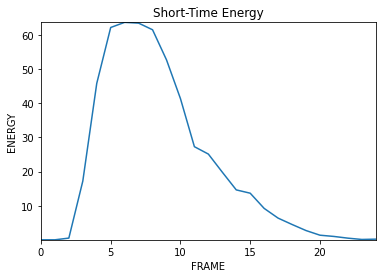

In [39]:
import matplotlib
import matplotlib.pyplot as pyplot
plt.plot(STEs)
plt.title('Short-Time Energy')
plt.ylabel('ENERGY')
plt.xlabel('FRAME')
pyplot.autoscale(tight='both');

In [ ]:
# Here's the code for the alternative method:

In [51]:
from math import pi
fc = 20
a = math.exp(-fc * 2 * pi / fs)
STEs = []
for n in range(len(signal)):
    if n == 0:
         STEs.append(a * 0 + signal[n] ** 2)           # base-case
    else:
         STEs.append(a * STEs[n - 1] + signal[n] ** 2)
 

In [ ]:
#And here's the plot of the results:

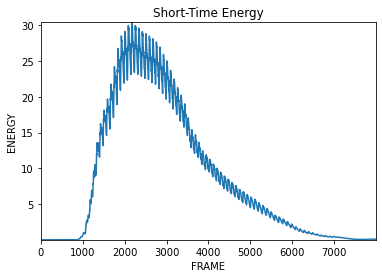

In [52]:
import matplotlib
import matplotlib.pyplot as pyplot
plt.plot(STEs)
plt.title('Short-Time Energy')
plt.ylabel('ENERGY')
plt.xlabel('FRAME')
pyplot.autoscale(tight='both');

# Short-Time Zero Crossing Count

In [ ]:
#First well remove any DC offset:

In [56]:
from statistics import mean
DC = mean(signal)
newSignal = signal - DC                 # create a new signal, preserving old
print ('DC               ==> ', DC)
print ('mean(newSignal)  ==> ', mean(newSignal))

DC               ==>  -0.0018053972545757073
mean(newSignal)  ==>  -2.0803671285651858e-18


In [ ]:
#Note that the mean of the new signal is really close to zero.

#Now we'll calculate the zero crossing counts:

In [57]:
assert fs % 1000 == 0
 
sampsPerMilli = int(fs / 1000)
millisPerFrame = 20
sampsPerFrame = sampsPerMilli * millisPerFrame
nFrames = int(len(signal) / sampsPerFrame)        # number of non-overlapping _full_ frames
 
print ('samples/millisecond  ==> ', sampsPerMilli)
print ('samples/[%dms]frame  ==> ' % millisPerFrame, sampsPerFrame)
print ('number of frames     ==> ', nFrames)
 

samples/millisecond  ==>  16
samples/s]frame  ==>  320
number of frames     ==>  25


In [63]:
import numpy as np
ZCCs = []                                      # list of short-time zero crossing counts
for i in range(nFrames):
    startIdx = i * sampsPerFrame
    stopIdx = startIdx + sampsPerFrame
    s = newSignal[startIdx:stopIdx]            # /s/ is the frame, named to correspond to the equation
    ZCC = 0
    for k in range(1, len(s)):
        ZCC += 0.5 * abs(np.sign(s[k]) - np.sign(s[k - 1]))
    ZCCs.append(ZCC)

In [ ]:
#And here's a plot of the results:
#The areas of the figure with very high (relative) zero crossing counts likely correspond to unvoiced regions of the signal.
#This method suffers in a noisy environment.

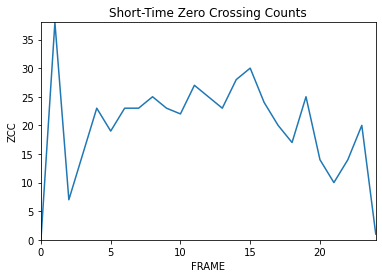

In [64]:
plt.plot(ZCCs)
plt.title('Short-Time Zero Crossing Counts')
plt.ylabel('ZCC')
plt.xlabel('FRAME')
pyplot.autoscale(tight='both');

# Pitch Period Estimation

In [ ]:
#Thus, the pitch period of the frame is simple determined by measuring the distance 
#(in samples) between the peaks of the autocorrelation graph.

In [67]:
# setup voiced frame times (based on name of file)
if fName == 'boy.wav':
    startTime = 0.45                      # of frame, units=seconds
    stopTime = 0.75                       # ditto
elif fName == 'boy.wav':
    startTime = 1.28                      # of frame, units=seconds
    stopTime = 1.36                       # ditto
else:
    assert False
#extract the frame
startIdx = int(startTime * fs)
stopIdx = int(stopTime * fs)
s = signal[startIdx:stopIdx]              # /s/ is the frame, named to correspond to the equation

In [ ]:
#We'll take a look at what we're dealing with (i.e., the frame):

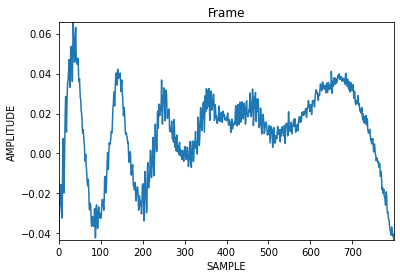

In [68]:
plt.plot(s)
plt.title('Frame')
plt.ylabel('AMPLITUDE')
plt.xlabel('SAMPLE')
pyplot.autoscale(tight='both');

In [ ]:
#And now for the actual autocorrelation:

In [70]:
phis = []
N = len(s)
for k in range(0, 400):
    phi = 0
    for n in range(k, N):
        phi += s[n] * s[n - k]
    phi *= 1 / N
    phis.append(phi)

In [ ]:
#And here's what the autocorrelation looks like:

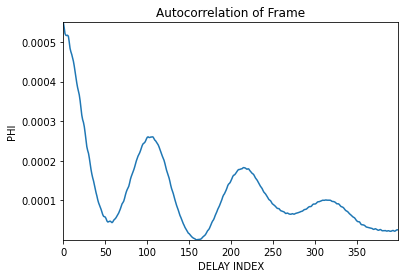

In [71]:
plt.plot(phis)
plt.title('Autocorrelation of Frame')
plt.ylabel('PHI')
plt.xlabel('DELAY INDEX')
pyplot.autoscale(tight='both');

# Average Magnitude Difference Function

In [ ]:
#Here's the AMDF code:

In [72]:
Ds = []
N = len(s)
for k in range(0, 400):
    D = 0
    for n in range(k, N):
        D += abs(s[n] - s[n - k])
    D *= 1 / N
    Ds.append(D)

In [ ]:
#And here's what it looks like
#The AMDF is actually easier to compute than the autocorrelation, and it looks like the troughs 
#might actually be easier to pick out automatically.

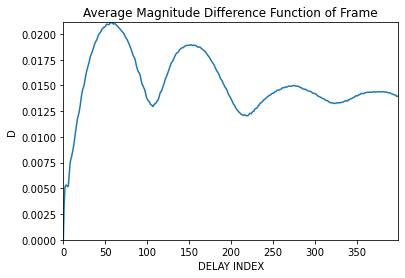

In [73]:
plt.plot(Ds)
plt.title('Average Magnitude Difference Function of Frame')
plt.ylabel('D')
plt.xlabel('DELAY INDEX')
pyplot.autoscale(tight='both');